In [15]:
import pandas as pd

df=pd.read_csv('food_orders.csv')
df.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


In [19]:
df.shape

(1000, 12)

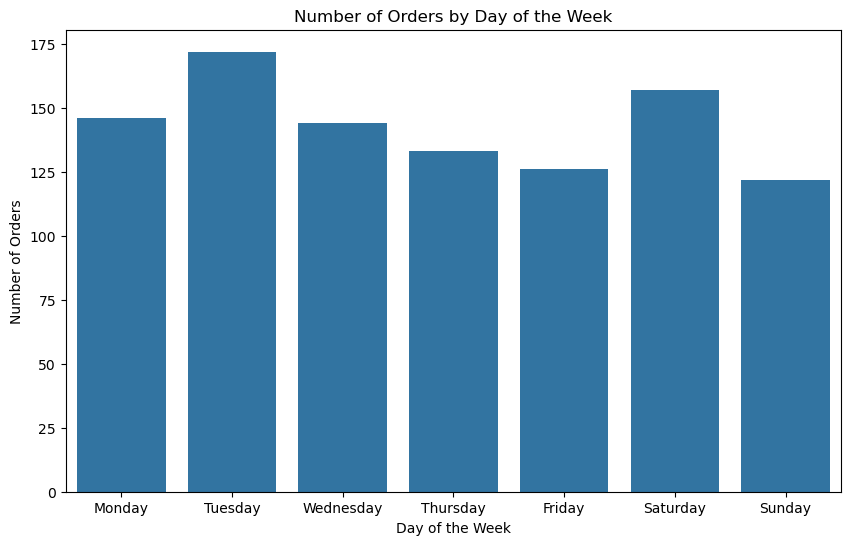

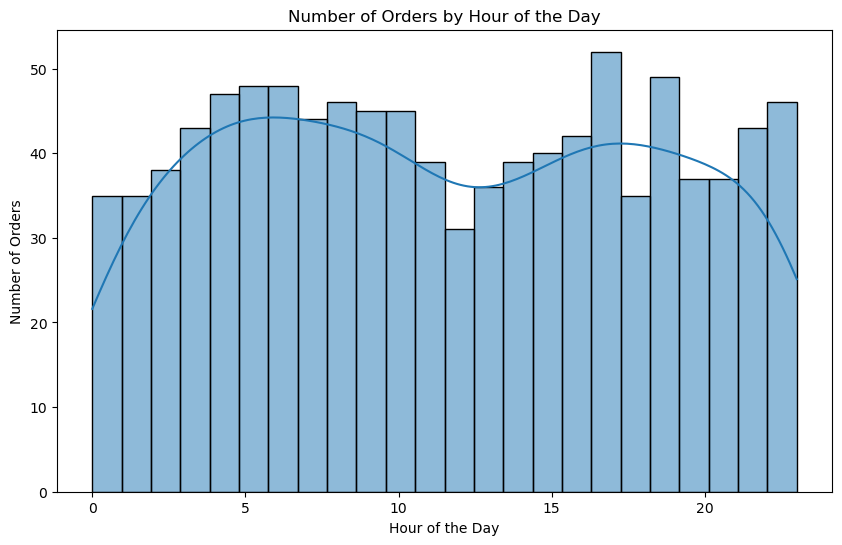

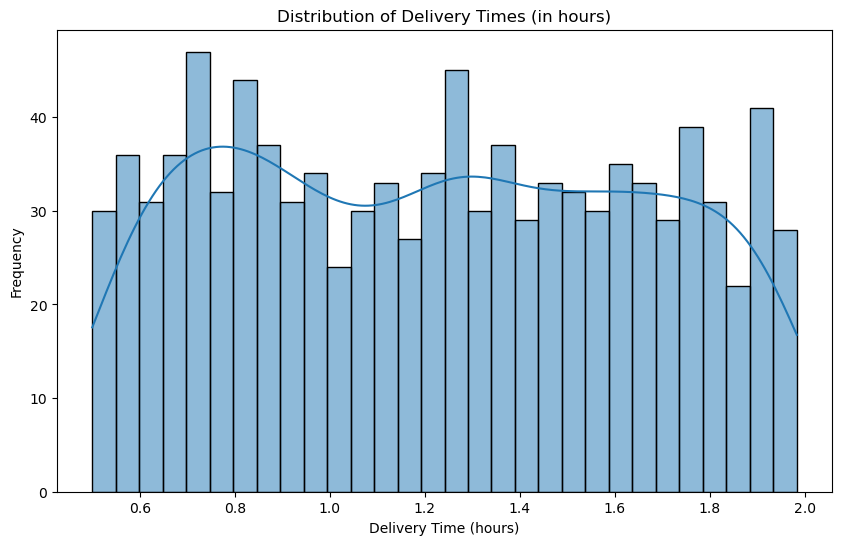

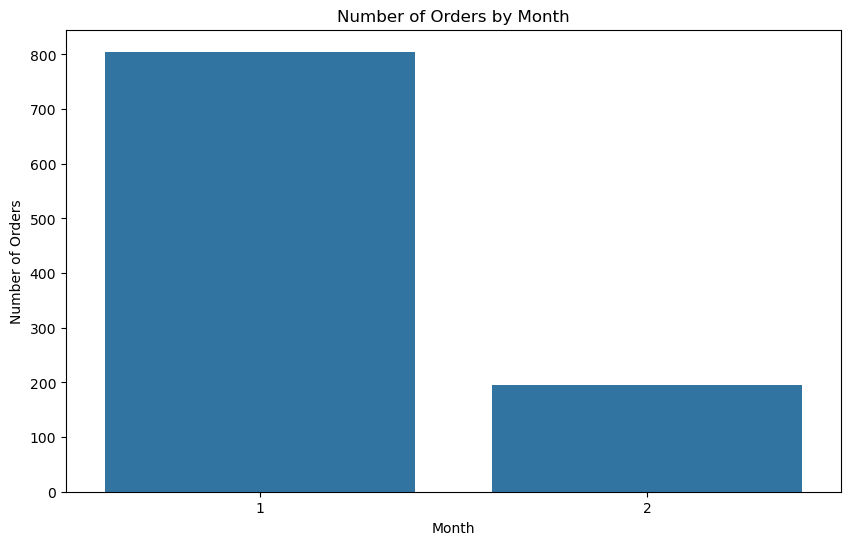

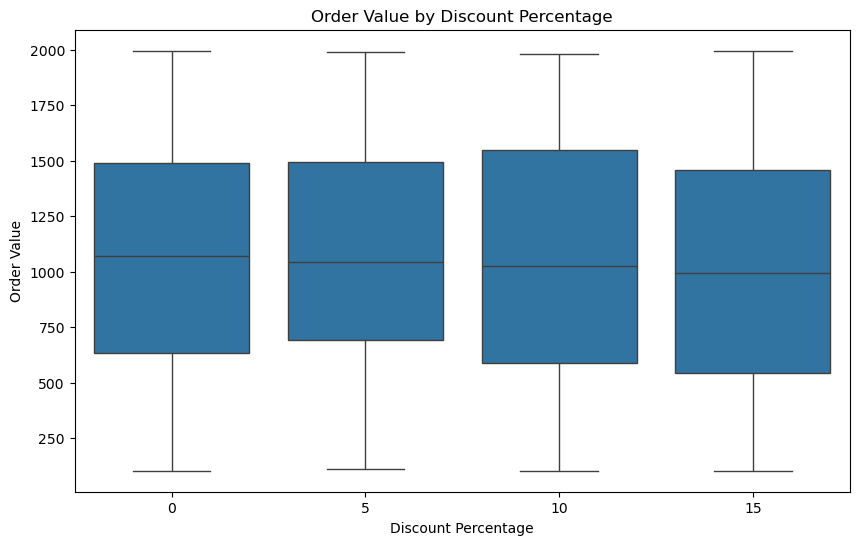

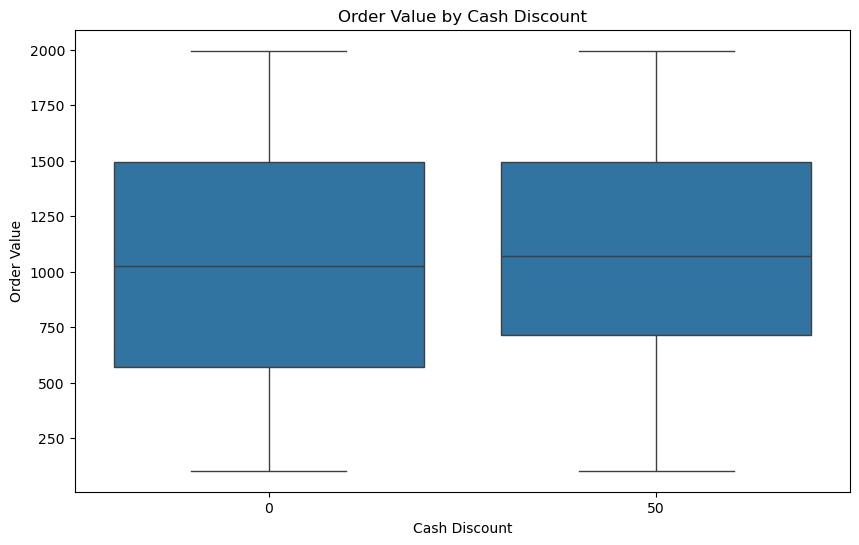

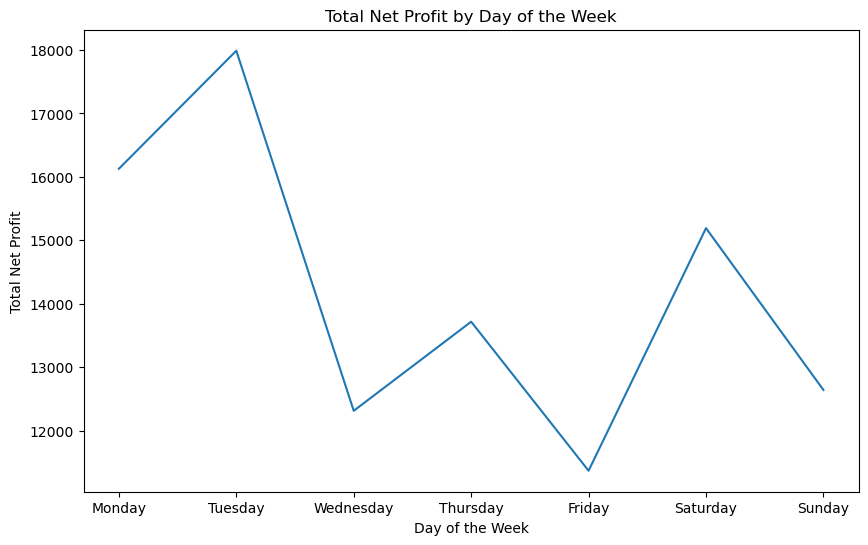

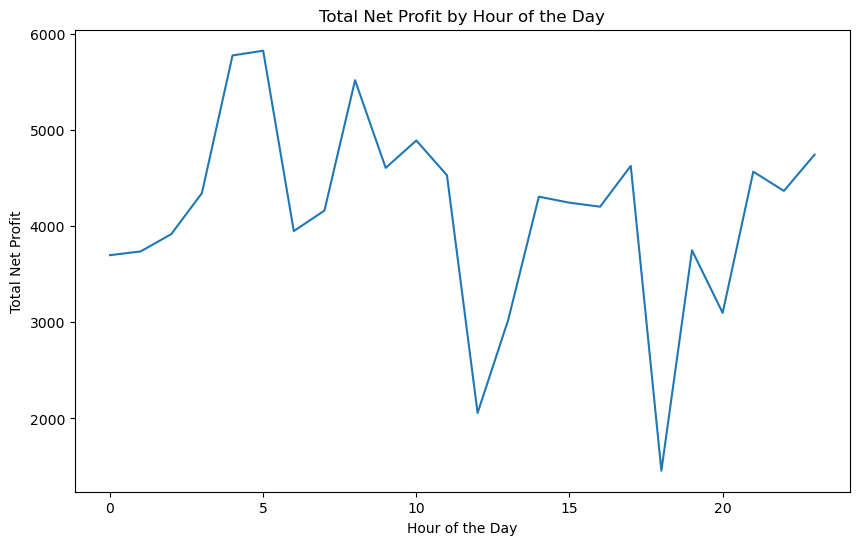

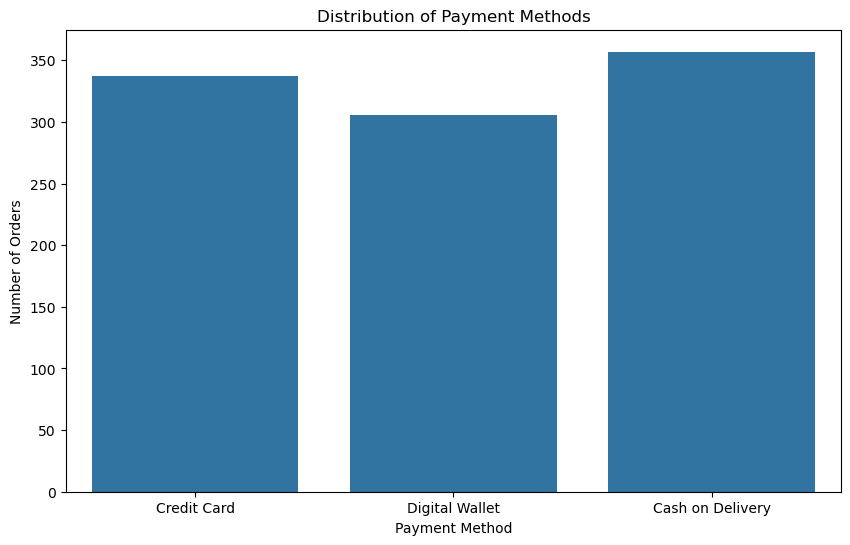

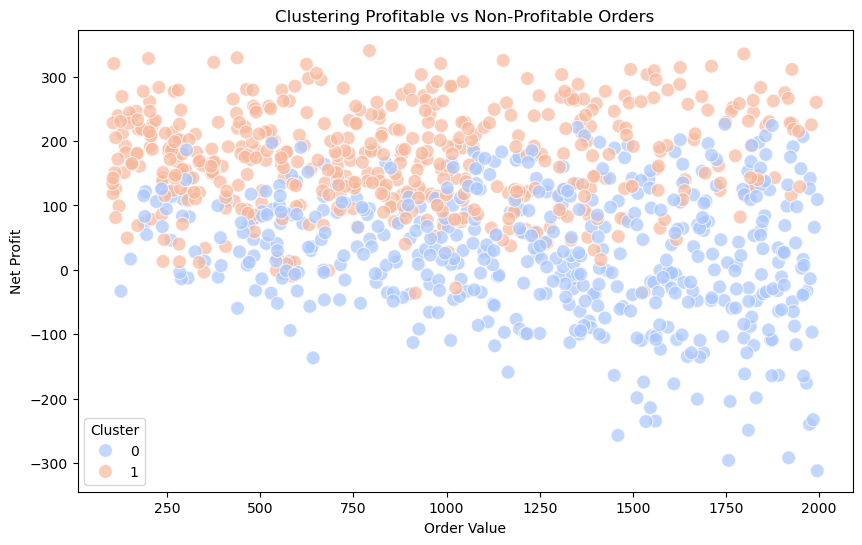

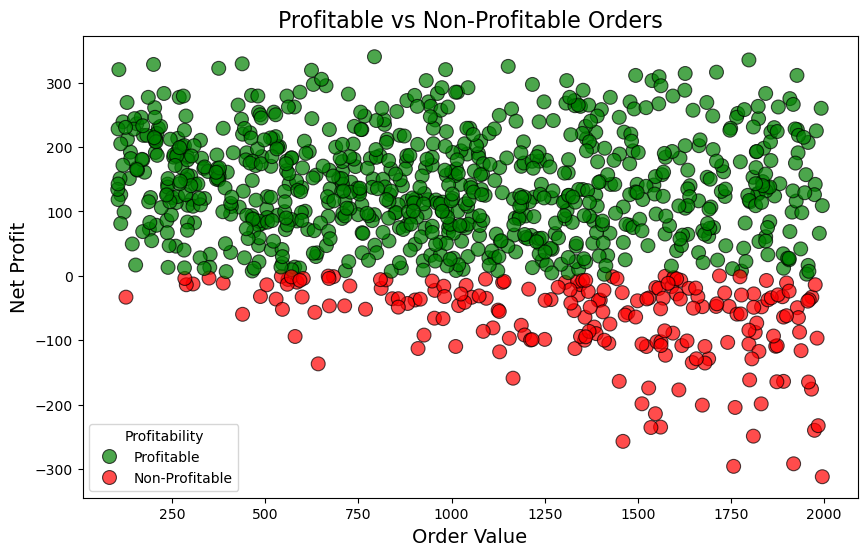

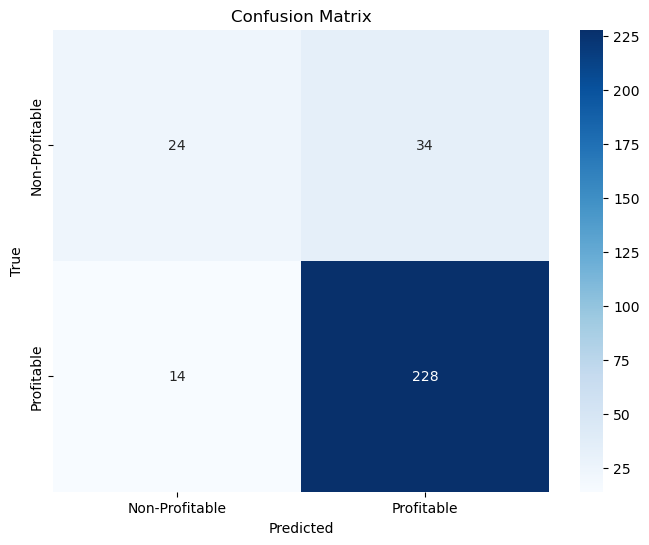

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.41      0.50        58
           1       0.87      0.94      0.90       242

    accuracy                           0.84       300
   macro avg       0.75      0.68      0.70       300
weighted avg       0.82      0.84      0.83       300



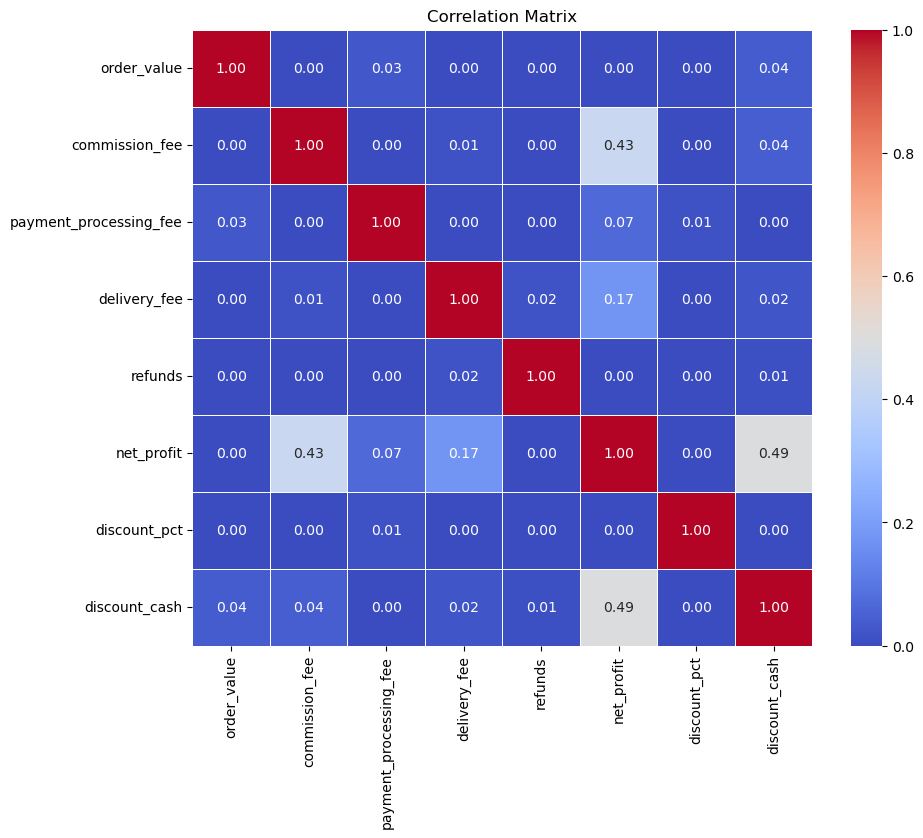

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

#----------------------------------------------------------------------------------------------------------------------------------------

#Data Loading

df=pd.read_csv('food_orders.csv')

#----------------------------------------------------------------------------------------------------------------------------------------

# Data Cleaning

df.columns = df.columns.str.lower().str.replace(' ','_')

df['order_date_and_time'] = pd.to_datetime(df['order_date_and_time'])
df['delivery_date_and_time'] = pd.to_datetime(df['delivery_date_and_time'])

df = df.rename(columns={'refunds/chargebacks': 'refunds'})

df['discounts_and_offers']=df['discounts_and_offers'].fillna('None')

def extract_percentage(offer):
    offer = str(offer)
    if '%' in offer:
        return int(str(offer).split('%')[0])
    return 0
def extract_cash(offer):
    offer = str(offer)
    words = offer.split()
    for word in words:
        if word.isdigit():
            return int(word)
    return 0
df['discount_pct'] = df['discounts_and_offers'].apply(extract_percentage)
df['discount_cash'] = df['discounts_and_offers'].apply(extract_cash)

df['discount_pct']=df['discount_pct'].fillna(0)
df['discount_cash']=df['discount_cash'].fillna(0)
df['order_value']=df['order_value'].fillna(0)
df['delivery_fee']=df['delivery_fee'].fillna(0)
df['commission_fee']=df['commission_fee'].fillna(0)
df['payment_processing_fee']=df['payment_processing_fee'].fillna(0)
df['refunds']=df['refunds'].fillna(0)

df[(df['discount_pct']<=100) & (df['discount_pct']>=0)]

df['net_profit']=df['commission_fee']-df['order_value']-df['refunds']+((df['order_value']+df['payment_processing_fee']+df['delivery_fee']+df['discount_cash'])*((100-df['discount_pct'])/100))

df['order_day_of_week'] = df['order_date_and_time'].dt.day_name()
df['order_hour'] = df['order_date_and_time'].dt.hour
df['order_month'] = df['order_date_and_time'].dt.month
df['delivery_time_hours'] = (df['delivery_date_and_time'] - df['order_date_and_time']).dt.total_seconds() / 3600

#----------------------------------------------------------------------------------------------------------------------------------------

#Outlier Detection and removal

continuous_vars=['order_value', 'commission_fee', 'payment_processing_fee', 'delivery_fee', 'net_profit','refunds']
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound)&(df[col] <= upper_bound)]
    return df
df_cleaned = remove_outliers(df, continuous_vars)

#----------------------------------------------------------------------------------------------------------------------------------------

#Analysis of no of orders wrt day of the week

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='order_day_of_week', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of Orders by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------

#Analysis of no of orders wrt hour of the day

plt.figure(figsize=(10, 6))
sns.histplot(df['order_hour'], bins=24, kde=True)
plt.title('Number of Orders by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------

#Analysis of no of orders wrt delivery time

plt.figure(figsize=(10, 6))
sns.histplot(df['delivery_time_hours'], bins=30, kde=True)
plt.title('Distribution of Delivery Times (in hours)')
plt.xlabel('Delivery Time (hours)')
plt.ylabel('Frequency')
plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------

#Analysis of no of orders wrt month

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='order_month', legend=False)
plt.title('Number of Orders by Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------

# Impact of discount on order price 

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='discount_pct', y='order_value')
plt.title('Order Value by Discount Percentage')
plt.xlabel('Discount Percentage')
plt.ylabel('Order Value')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='discount_cash', y='order_value')
plt.title('Order Value by Cash Discount')
plt.xlabel('Cash Discount')
plt.ylabel('Order Value')
plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------

# Analyzing total net profit by day of the week and hour of the day

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['order_day_of_week'] = pd.Categorical(df['order_day_of_week'], categories=day_order, ordered=True)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='order_day_of_week', y='net_profit', estimator='sum', errorbar=None)
plt.title('Total Net Profit by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Net Profit')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='order_hour', y='net_profit', estimator='sum', errorbar=None)
plt.title('Total Net Profit by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Net Profit')
plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------

#Analyzing distribution of payment methods

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='payment_method')
plt.title('Distribution of Payment Methods')
plt.xlabel('Payment Method')
plt.ylabel('Number of Orders')
plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------

# K means clustering to cluster orders

features = ['order_value', 'commission_fee', 'delivery_time_hours', 'net_profit']
df_for_clustering = df[features]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_for_clustering)
kmeans = KMeans(n_clusters=2, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(df_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='order_value', y='net_profit', hue='kmeans_cluster', palette='coolwarm', data=df, s=100, alpha=0.7)
plt.title('Clustering Profitable vs Non-Profitable Orders')
plt.xlabel('Order Value')
plt.ylabel('Net Profit')
plt.legend(title='Cluster')
plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------

# Analyzing profitable and non profitable records in scatter plot

df['profitability'] = df['net_profit'].apply(lambda x: 'Profitable' if x > 0 else 'Non-Profitable')
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='order_value', 
    y='net_profit', 
    hue='profitability',         
    palette={'Profitable': 'green', 'Non-Profitable': 'red'},  
    data=df, 
    s=100,                       
    alpha=0.7,                   
    edgecolor='k'
)
plt.title('Profitable vs Non-Profitable Orders', fontsize=16)
plt.xlabel('Order Value', fontsize=14)
plt.ylabel('Net Profit', fontsize=14)
plt.legend(title='Profitability')
plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------

# Confusion matrix

df['true_profitability'] = df['net_profit'].apply(lambda x: 1 if x > 0 else 0)
features = ['order_value', 'commission_fee', 'delivery_time_hours', 'discount_pct', 'discount_cash','refunds']
X = df[features]
y = df['true_profitability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors as needed
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Profitable', 'Profitable'], yticklabels=['Non-Profitable', 'Profitable'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("Classification Report:")
print(classification_report(y_test, y_pred))

#----------------------------------------------------------------------------------------------------------------------------------------

# Correlation matrix

correlation_data = df[['order_value', 'commission_fee', 'payment_processing_fee', 'delivery_fee','refunds', 
                       'net_profit', 'discount_pct', 'discount_cash']]
correlation_matrix = correlation_data.corr()
correlation_matrix = correlation_matrix.clip(lower=0, upper=1)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=0, vmax=1)
plt.title('Correlation Matrix')
plt.show()




In [27]:
df.head()

,order_id,customer_id,restaurant_id,order_date_and_time,delivery_date_and_time,order_value,delivery_fee,payment_method,discounts_and_offers,commission_fee,...,discount_pct,discount_cash,net_profit,order_day_of_week,order_hour,order_month,delivery_time_hours,kmeans_cluster,profitability,true_profitability
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,...,5,0,98.95,Thursday,1,2,1.466667,0,Profitable,1
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,...,10,0,156.10,Friday,22,2,0.583333,1,Profitable,1
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,...,15,0,118.20,Wednesday,5,1,0.966667,1,Profitable,1
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,None,146,...,0,0,223.00,Tuesday,22,1,0.766667,1,Profitable,1
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,...,0,50,260.00,Monday,1,1,1.483333,1,Profitable,1
